# VS associations with cognitive performance (P) with an interaction with DRD2 polymorphism

***

In [2]:
import matplotlib.pyplot as plt
import ptitprince as pt
import pandas as pd
import numpy as np
import random
from scipy import stats
from scipy.stats import beta
from scipy.special import betaln
#from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.core.display import HTML
#import pymc3 as pm
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

### Loading Datasets

In [65]:
# Loading data
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

# Loading second IGT only data (Reformatted)
IGT_data = pd.read_csv('DRD2_IGT_subset_data.csv', delimiter=',')
IGT_data = IGT_data.dropna(subset=['IGT_scores', 'DRD2'])

In [66]:
data

,AGE,female_1,P,Q,VS,Obesity,DRD2,IGT_score_type,IGT_scores,LABID
1,49.0,1.0,-4.0,12.0,-0.099976,1.283069,0.0,P,-4.0,30390.0
2,35.0,1.0,44.0,62.0,0.334085,-1.102770,0.0,P,44.0,30407.0
3,45.0,1.0,18.0,36.0,0.532905,0.619251,1.0,P,18.0,30435.0
4,30.0,1.0,52.0,10.0,0.164745,-0.433993,0.0,P,52.0,30437.0
5,33.0,1.0,-22.0,50.0,-0.031081,-1.746404,0.0,P,-22.0,30465.0
...,...,...,...,...,...,...,...,...,...,...
485,47.0,1.0,-32.0,56.0,0.052435,-1.203731,1.0,P,-32.0,59695.0
486,31.0,0.0,38.0,36.0,0.297740,0.154226,0.0,P,38.0,59699.0
487,41.0,1.0,-4.0,20.0,0.054609,1.533072,0.0,P,-4.0,59722.0
488,37.0,0.0,-16.0,44.0,0.073163,-0.920912,0.0,P,-16.0,59946.0


### Reformatting Data

In [5]:
# Changing Categorical data to integers
data['DRD2'] = data['DRD2'].astype(int)
data['female_1'] = data['female_1'].astype(int)
IGT_data['DRD2'] = IGT_data['DRD2'].astype(int)

# Changing DRD2 data to category type
data['DRD2_cat'] = pd.cut(data['DRD2'], range(-1,2,1), labels=['-141C Ins/Del Carrier', 'Non-Carrier'])
data['DRD2_cat'] = data['DRD2_cat'].astype('object')
IGT_data['DRD2_cat'] = pd.cut(IGT_data['DRD2'], range(-1,2,1), labels=['-141C Ins/Del Carrier', 'Non-Carrier'])
IGT_data['DRD2_cat'] = IGT_data['DRD2_cat'].astype('object')

# Splitting data based on DRD2 polymorphism
low = data[data['DRD2'] == 1] # Low D2 Receptors
normal = data[data['DRD2'] == 0] # Normal D2 Receptors

## Distribution Plots

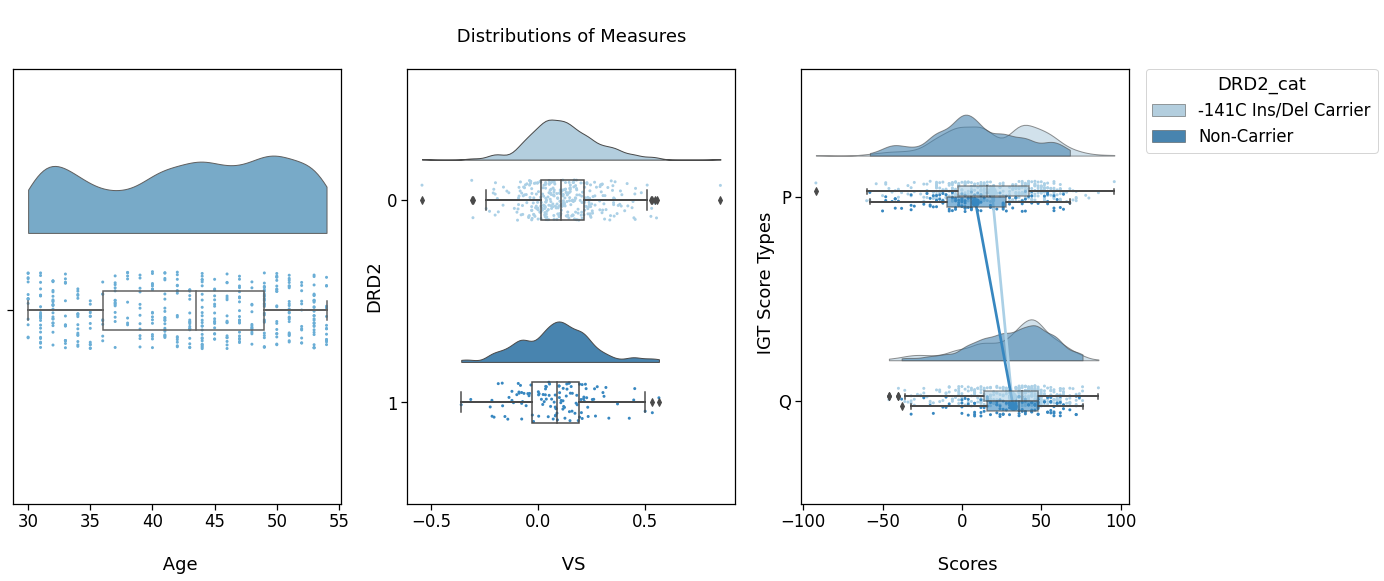

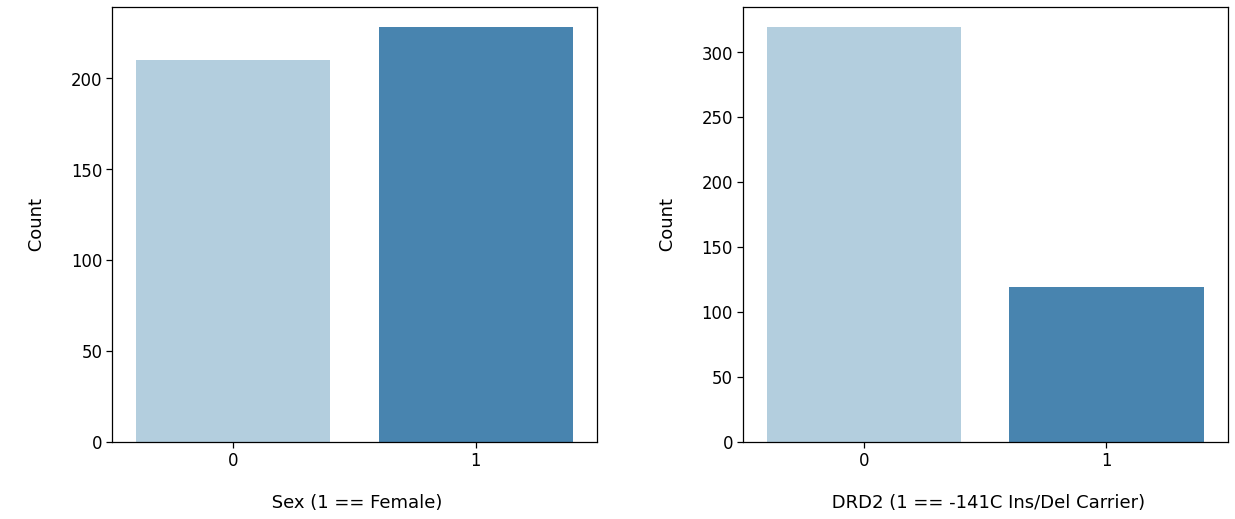

In [19]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)


# Age Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
age = pt.RainCloud(y='AGE', orient='h',data=data, width_viol=.4, width_box=.1, 
                   palette="Blues",ax=ax)
age.set(xlabel='\n Age')

# VS Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS = pt.RainCloud(y='VS', x='DRD2', data=data, orient='h', width_viol=.4, width_box=.2, 
                  palette="Blues", ax=ax)
VS.set(xlabel='\n VS', title='\n Distributions of Measures \n')

# IGT Scores Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
IGT = pt.RainCloud(y='IGT_scores', x='IGT_score_type', hue='DRD2_cat', data=IGT_data, orient='h', 
                         width_viol=.4, width_box=.1, palette='Blues', alpha=.6, ax=ax,
                          dodge=True, pointplot=True) #Can comment out if lines aren't helpful
IGT.set(xlabel='\n Scores', ylabel='\n IGT Score Types')

# Configuring 2nd row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.3)
fig.set_figheight(8)
fig.set_figwidth(20)

# Sex Bar Plot
ax = fig.add_subplot(1, 2, 1)
sex = sns.countplot(x="female_1", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n Sex (1 == Female)', ylabel='\n Count \n')

# DRD2 Bar Plot
ax = fig.add_subplot(1, 2, 2)
DRD2 = sns.countplot(x="DRD2", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n DRD2 (1 == -141C Ins/Del Carrier)', ylabel='\n Count \n')

plt.close(3)
plt.close(4)

plt.show()

***


# T-Tests

### T-Test between DRD2 vs P and Q

In [20]:
t_test_results = stats.ttest_ind(low.iloc[:,2:5], normal.iloc[:,2:5], equal_var=True)
cols = ['P', 'Q', 'VS']
pd.DataFrame({'Statistics':t_test_results.statistic[0:], 'P-values':t_test_results.pvalue}, cols)


,Statistics,P-values
P,-3.230837,0.001328
Q,0.539049,0.590128
VS,-1.771730,0.077138


### Linear Regression Plots

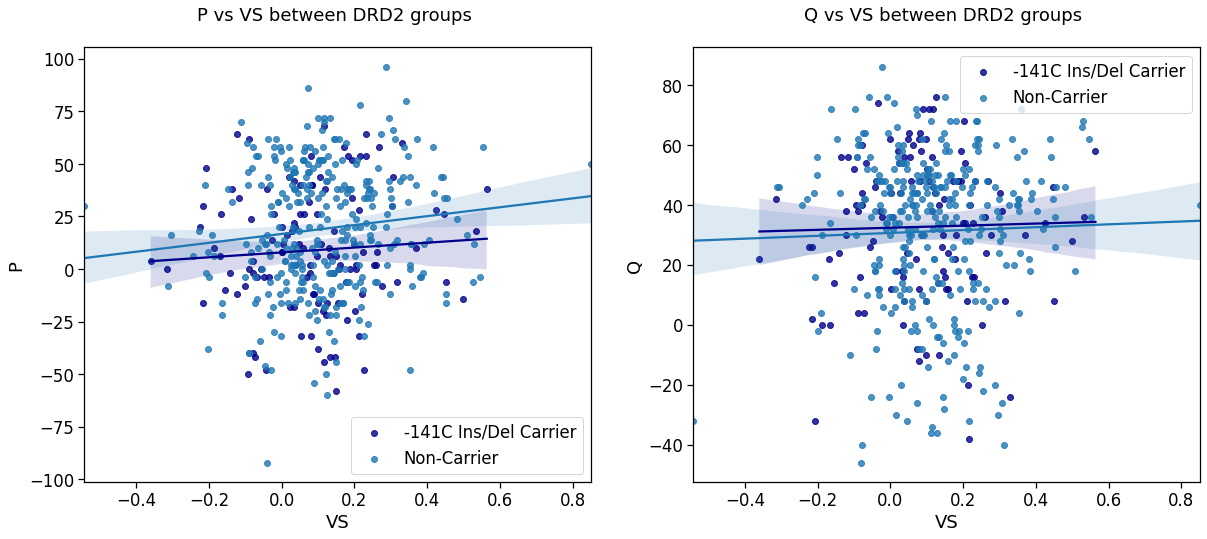

In [21]:
# Configuring grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)

# P vs VS between DRD2 groups Scatter Plot
ax = fig.add_subplot(1, 2, 1)
scatter_P_low = sns.regplot(x='VS', y='P', data=low, label='-141C Ins/Del Carrier', color="darkblue", ax=ax).legend()
scatter_P_normal = sns.regplot(x='VS', y='P', data=normal, label='Non-Carrier').legend()
ax.set(title='P vs VS between DRD2 groups \n')

# Q vs VS between DRD2 groups Scatter Plot
ax = fig.add_subplot(1, 2, 2)
scatter_Q_low = sns.regplot(x='VS', y='Q', data=low, label='-141C Ins/Del Carrier', color="darkblue", ax=ax).legend()
scatter_Q_normal = sns.regplot(x='VS', y='Q', data=normal, label='Non-Carrier').legend()
ax.set(title='Q vs VS between DRD2 groups \n')
plt.show()

*****


# Linear Regression and Bootstrapped Bayes Factor

## Bootstrap Function

In [22]:
def resample(n):
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

## P ~ DRD2 + VS + DRD2 * VS

In [23]:
results_P = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_P.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


### Bayes Factor

### Bootstrap

## Q ~ DRD2 + VS + DRD2 * VS

In [26]:
results_Q = smf.ols(formula='Q ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_Q.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.746,17.563,0.000,27.230,34.092
DRD2,1.7348,3.140,0.553,0.581,-4.437,7.906
VS,4.7830,8.658,0.552,0.581,-12.234,21.801
DRD2:VS,-1.3082,16.272,-0.080,0.936,-33.289,30.673


***

### Slope Comparison Between Groups

In [27]:
carrier = data[data['DRD2'] == 1]
noncarrier = data[data['DRD2'] == 0] 

## P ~  VS

#### Ins/Ins Carriers

In [28]:
results_P_carrier = smf.ols(formula='P ~ VS',data=carrier).fit()
HTML(results_P_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.9134,2.939,2.692,0.008,2.092,13.734
VS,11.5671,15.515,0.746,0.457,-19.159,42.293


#### Non-Carriers

In [29]:
results_P_noncarrier = smf.ols(formula='P ~ VS', data=noncarrier).fit()
HTML(results_P_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.040,8.189,0.000,12.691,20.717
VS,21.1400,10.117,2.090,0.037,1.235,41.045


## Q ~  VS

#### Ins/Ins Carriers

In [30]:
results_Q_carrier = smf.ols(formula='Q ~ VS',data=carrier).fit()
HTML(results_Q_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.3955,2.426,13.353,0.000,27.591,37.200
VS,3.4748,12.806,0.271,0.787,-21.887,28.837


#### Non-Carriers

In [31]:
results_Q_noncarrier = smf.ols(formula='Q ~ VS',data=noncarrier).fit()
HTML(results_Q_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.789,17.139,0.000,27.141,34.180
VS,4.7830,8.873,0.539,0.590,-12.674,22.240


In [32]:
np.random.seed(123)

def permutationTest(y, diff):
    
    diff_collection = []
    greaterDiff_count = 0
    total = 1500
    sample_size = 438
    
    for i in range(0, total):
        
        # Randomizing DRD2 Assignment
        DRD2_rand = np.random.choice(np.array(data['DRD2']), 438, replace = False)
        VS = np.array(data['VS'])
        y_data = np.array(data[y])
        perm_data = pd.DataFrame({'DRD2_rand':DRD2_rand, 'VS':VS, 'y':y_data})
        
        # Splitting by DRD2 Assignment
        carrier_rand_data = perm_data[perm_data['DRD2_rand'] == 1]
        noncarrier_rand_data = perm_data[perm_data['DRD2_rand'] == 0]
 
        # Carrier Linear Regression
        carrier_rand_res = smf.ols(formula = 'y ~ VS', data=carrier_rand_data).fit()
        carrier_coef = carrier_rand_res.params[1]
        
        # Non-Carrier Linear Regression
        noncarrier_rand_res = smf.ols(formula = 'y ~ VS', data=noncarrier_rand_data).fit()
        noncarrier_coef = noncarrier_rand_res.params[1]
        
        # Calculating Permuted Difference
        rand_diff = noncarrier_coef - carrier_coef
        
        # Collecting Permuted Differences
        diff_collection.append(rand_diff)
        
        # Counting Greater Permuted Differences 
        if rand_diff > diff:
            greaterDiff_count += 1
    
    # Calculating Fraction of Greater Permuted Differences
    PVal  = greaterDiff_count / total
    
    plt.hist(diff_collection, bins=25, edgecolor='k')
    plt.axvline(x=diff, color='black', linestyle='dashed')
    
    return PVal

0.30266666666666664

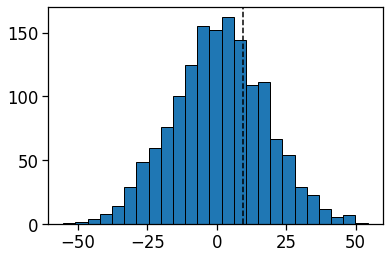

In [33]:
difference = results_P_noncarrier.params[1] - results_P_carrier.params[1]
permutationTest('P', difference)

0.4646666666666667

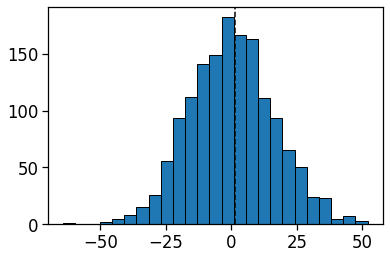

In [34]:
difference = results_Q_noncarrier.params[1] - results_Q_carrier.params[1]
permutationTest('Q', difference)

### VS Quantile Exploration

In [79]:
VS_data = data
VS_data.sort_values(by =['VS'], inplace = True)
VS_data['QuantileRank']= pd.qcut(data['VS'], q = 4, labels = False)
VS_data_1 = VS_data[VS_data["QuantileRank"] == 0]
VS_data_2 = VS_data[VS_data["QuantileRank"] == 1]
VS_data_3 = VS_data[VS_data["QuantileRank"] == 2]
VS_data_4 = VS_data[VS_data["QuantileRank"] == 3]

[Text(0.5, 0, '\n TOP Quintile 4')]

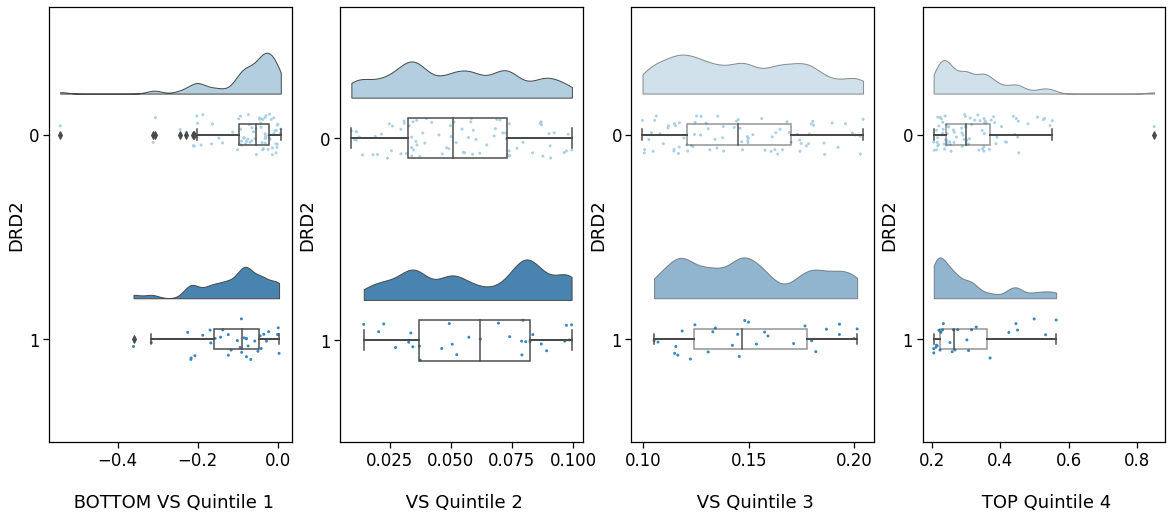

In [40]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)


# VS Q1 Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
age = pt.RainCloud(y='VS', x='DRD2', orient='h',data=VS_data_1, width_viol=.4, width_box=.1, 
                   palette='Blues',ax=ax)
age.set(xlabel='\n BOTTOM VS Tertile 1')

# VS Q2 Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS = pt.RainCloud(y='VS', x='DRD2', data=VS_data_2, orient='h', width_viol=.4, width_box=.2, 
                  palette='Blues', ax=ax)
VS.set(xlabel='\n VS Tertile 2')

# VS Q3 Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
IGT = pt.RainCloud(y='VS', x='DRD2', data=VS_data_3, orient='h', width_viol=.4, width_box=.1, 
                   palette='Blues', ax=ax)
IGT.set(xlabel='\n VS Tertile 3')

# VS Q4 Rain Cloud Plots
ax = fig.add_subplot(1, 4, 4)
IGT = pt.RainCloud(y='VS', x='DRD2', data=VS_data_4, orient='h', width_viol=.4, width_box=.1, 
                   palette='Blues', ax=ax)
IGT.set(xlabel='\n TOP VS Tertile 4')

Text(0.5, 1.0, 'VS Quartile 4 \n')

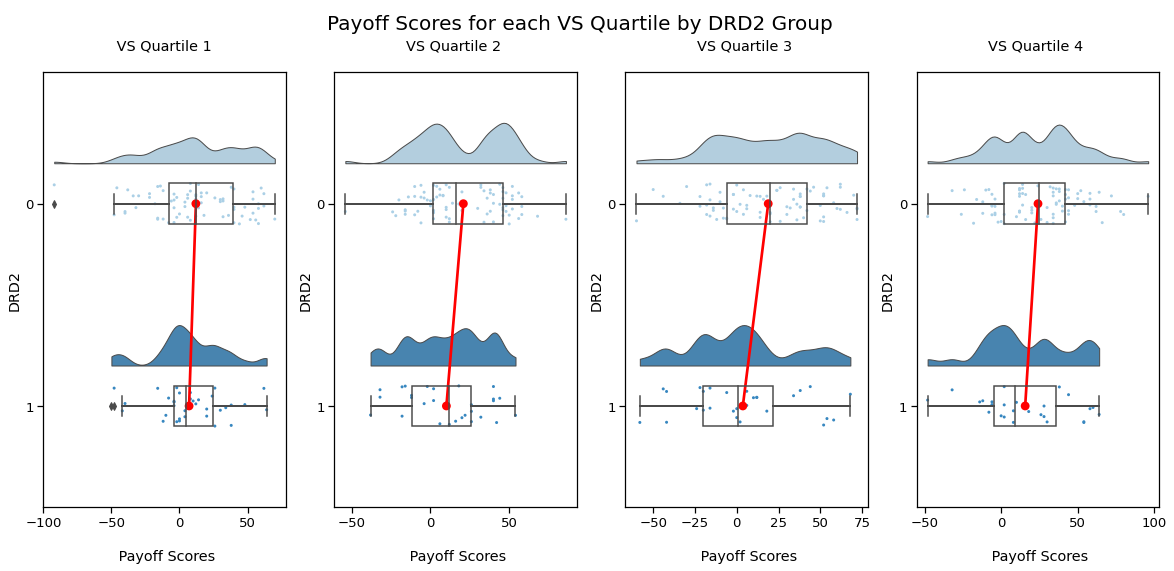

In [35]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.2)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Payoff Scores for each VS Quartile by DRD2 Group \n \n ', fontsize=20)


# VS Q1 Rain Cloud Plot
ax = fig.add_subplot(1, 4, 1)
VS_1 = pt.RainCloud(y='P', x='DRD2', orient='h',data=VS_data_1, width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=ax)
VS_1.set(xlabel='\n Payoff Scores')
VS_1.set_title('VS Quartile 1 \n')

# VS Q2 Rain Cloud Plot
ax = fig.add_subplot(1, 4, 2)
VS_2 = pt.RainCloud(y='P', x='DRD2', data=VS_data_2, orient='h', width_viol=.4, width_box=.2, 
                  palette='Blues', pointplot=True, ax=ax)
VS_2.set(xlabel='\n Payoff Scores')
VS_2.set_title('VS Quartile 2 \n')

# VS Q3 Rain Cloud Plots
ax = fig.add_subplot(1, 4, 3)
VS_3 = pt.RainCloud(y='P', x='DRD2', data=VS_data_3, orient='h', width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=ax) 
VS_3.set(xlabel='\n Payoff Scores')
VS_3.set_title('VS Quartile 3 \n')

# VS Q4 Rain Cloud Plots
ax = fig.add_subplot(1, 4, 4)
VS_4 = pt.RainCloud(y='P', x='DRD2', data=VS_data_4, orient='h', width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=ax)
VS_4.set(xlabel='\n Payoff Scores')
VS_4.set_title('VS Quartile 4 \n')

# Linear Regression Models for VS Quartiles
---
## P ~ DRD2

VS Quartile 1

In [21]:
results_P_VS_1 = smf.ols(formula='P ~ DRD2',data=VS_data_1).fit()
HTML(results_P_VS_1.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.0541,3.589,3.359,0.001,4.941,19.167
DRD2,-4.9985,6.273,-0.797,0.427,-17.433,7.436


VS Quartile 2

In [12]:
results_P_VS_2 = smf.ols(formula='P ~ DRD2',data=VS_data_2).fit()
HTML(results_P_VS_2.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,20.9000,2.978,7.018,0.000,14.996,26.804
DRD2,-10.7621,5.774,-1.864,0.065,-22.208,0.684


VS Quartile 3

In [13]:
results_P_VS_3 = smf.ols(formula='P ~ DRD2',data=VS_data_3).fit()
HTML(results_P_VS_3.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.8395,3.544,5.316,0.000,11.814,25.865
DRD2,-15.1966,6.992,-2.173,0.032,-29.058,-1.335


VS Quartile 4

In [14]:
results_P_VS_4 = smf.ols(formula='P ~ DRD2',data=VS_data_4).fit()
HTML(results_P_VS_4.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,24.0714,3.077,7.822,0.000,17.972,30.171
DRD2,-8.3791,6.329,-1.324,0.188,-20.925,4.167


## Linear Regression Plots for each Quartile by Group

Text(0.5, 1.0, 'Quartile 4')

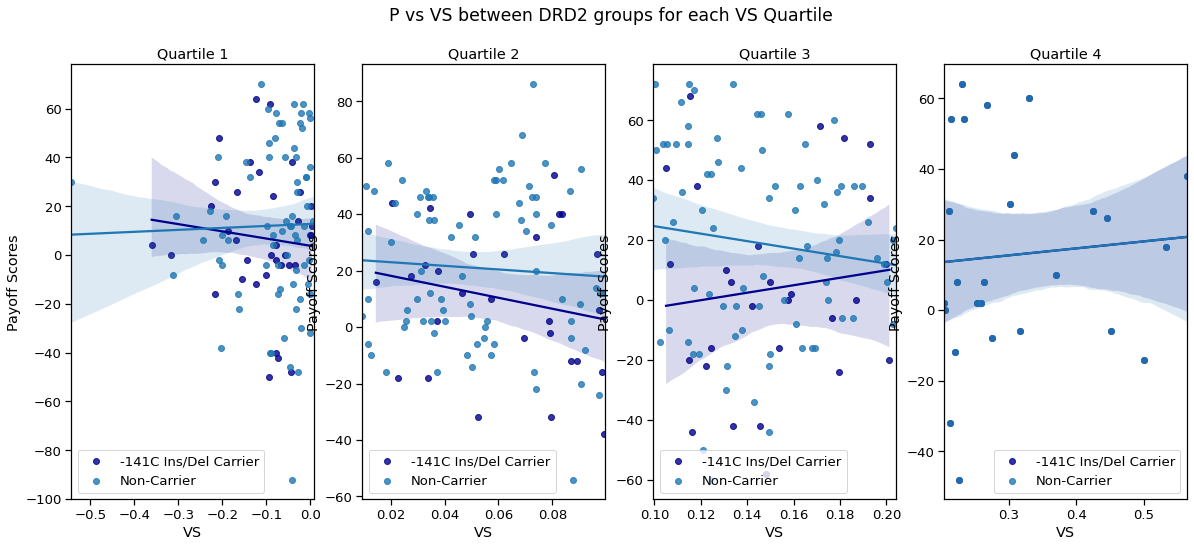

In [84]:
# Configuring grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('P vs VS between DRD2 groups for each VS Quartile\n')

# Q1
ax = fig.add_subplot(1, 4, 1)
scatter_P_carrier_1 = sns.regplot(x='VS', y='P', data=VS_data_1[VS_data_1["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_1 = sns.regplot(x='VS', y='P', data=VS_data_1[VS_data_1["DRD2"]==0], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Quartile 1')

# Q2
ax = fig.add_subplot(1, 4, 2)
scatter_P_carrier_2 = sns.regplot(x='VS', y='P', data=VS_data_2[VS_data_2["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_2 = sns.regplot(x='VS', y='P', data=VS_data_2[VS_data_2["DRD2"]==0], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Quartile 2')

#Q3
ax = fig.add_subplot(1, 4, 3)
scatter_P_carrier_3 = sns.regplot(x='VS', y='P', data=VS_data_3[VS_data_3["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_3 = sns.regplot(x='VS', y='P', data=VS_data_3[VS_data_3["DRD2"]==0], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Quartile 3')

#Q4
ax = fig.add_subplot(1, 4, 4)
scatter_P_carrier_4 = sns.regplot(x='VS', y='P', data=VS_data_4[VS_data_4["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_4 = sns.regplot(x='VS', y='P', data=VS_data_4[VS_data_4["DRD2"]==1], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Quartile 4')

## P ~ DRD2 + VS + DRD2*VS

VS Quartile 1

In [23]:
results2_P_VS_1 = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=VS_data_1).fit()
HTML(results2_P_VS_1.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.7202,4.859,2.618,0.010,3.087,22.354
DRD2,-8.9159,9.772,-0.912,0.364,-28.290,10.459
VS,8.0391,39.146,0.205,0.838,-69.571,85.649
DRD2:VS,-37.5555,72.388,-0.519,0.605,-181.073,105.962


VS Quartile 2

In [24]:
results2_P_VS_2 = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=VS_data_2).fit()
HTML(results2_P_VS_2.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,24.2460,6.821,3.554,0.001,10.720,37.772
DRD2,-2.2196,14.350,-0.155,0.877,-30.673,26.234
VS,-64.2739,117.801,-0.546,0.586,-297.852,169.304
DRD2:VS,-130.0169,223.324,-0.582,0.562,-572.827,312.793


VS Quartile 3

In [25]:
results2_P_VS_3 = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=VS_data_3).fit()
HTML(results2_P_VS_3.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,37.1018,17.772,2.088,0.039,1.863,72.340
DRD2,-52.2055,36.087,-1.447,0.151,-123.760,19.349
VS,-125.0674,119.253,-1.049,0.297,-361.524,111.389
DRD2:VS,249.9417,237.426,1.053,0.295,-220.830,720.713


VS Quartile 4

In [26]:
results2_P_VS_4 = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=VS_data_4).fit()
HTML(results2_P_VS_4.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,20.7704,9.928,2.092,0.039,1.088,40.453
DRD2,-11.2076,19.645,-0.570,0.570,-50.157,27.741
VS,10.1945,29.124,0.350,0.727,-47.546,67.935
DRD2:VS,9.6220,59.389,0.162,0.872,-108.122,127.366


Text(0.5, 1.0, 'VS Tertile 3 \n')

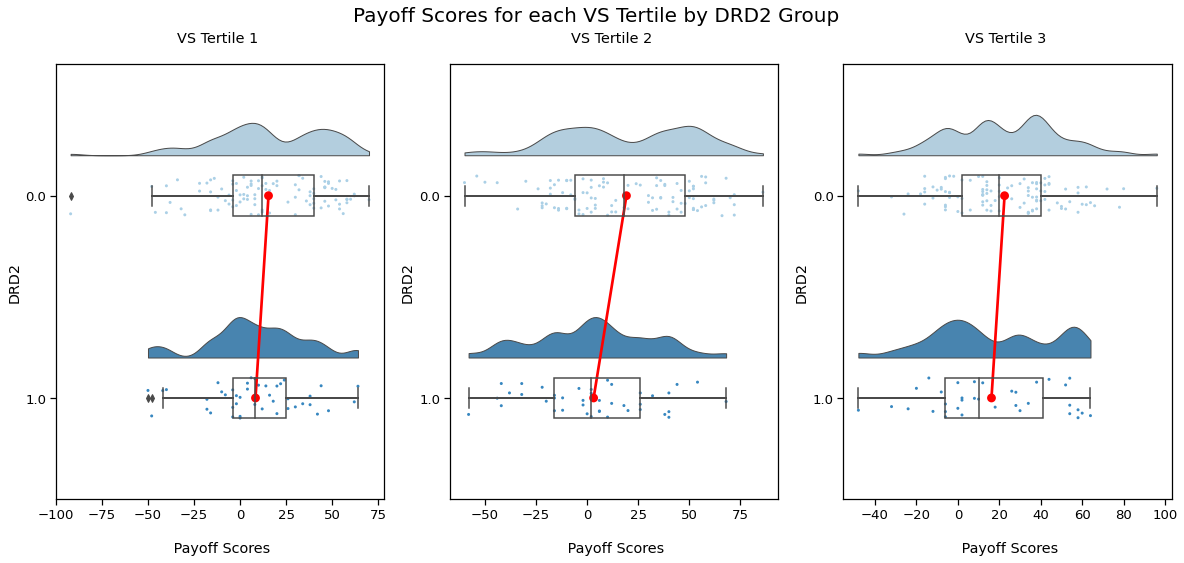

In [86]:
VS_data = data
VS_data.sort_values(by =['VS'], inplace = True)
VS_data['QuantileRank']= pd.qcut(data['VS'], q = 3, labels = False)
VS_data_1T = VS_data[VS_data["QuantileRank"] == 0]
VS_data_2T = VS_data[VS_data["QuantileRank"] == 1]
VS_data_3T = VS_data[VS_data["QuantileRank"] == 2]


# Setting style of figures
sns.set_context("notebook", font_scale=1.2)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Payoff Scores for each VS Tertile by DRD2 Group', fontsize=20, ha='center')


# VS Q1 Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
VS_1 = pt.RainCloud(y='P', x='DRD2', orient='h',data=VS_data_1T, width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=ax)
VS_1.set(xlabel='\n Payoff Scores')
VS_1.set_title('VS Tertile 1 \n')

# VS Q2 Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS_2 = pt.RainCloud(y='P', x='DRD2', data=VS_data_2T, orient='h', width_viol=.4, width_box=.2, 
                  palette='Blues', pointplot=True, ax=ax)
VS_2.set(xlabel='\n Payoff Scores')
VS_2.set_title('VS Tertile 2 \n')

# VS Q3 Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
VS_3 = pt.RainCloud(y='P', x='DRD2', data=VS_data_3T, orient='h', width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=ax) 
VS_3.set(xlabel='\n Payoff Scores')
VS_3.set_title('VS Tertile 3 \n')


In [72]:
num1 = VS_data_1T[VS_data_1T["DRD2"] == 1].shape[0]
denom1 = VS_data_1T[VS_data_1T["DRD2"] == 0].shape[0]

num2 = VS_data_2T[VS_data_2T["DRD2"] == 1].shape[0]
denom2 = VS_data_2T[VS_data_2T["DRD2"] == 0].shape[0]

num3 = VS_data_3T[VS_data_3T["DRD2"] == 1].shape[0]
denom3 = VS_data_3T[VS_data_3T["DRD2"] == 0].shape[0]


print((num1/denom1), (num2/denom2), (num3/denom3))

0.4174757281553398 0.3904761904761905 0.3153153153153153


In [91]:
results_P_VS_1T = smf.ols(formula='P ~ DRD2 + AGE + DRD2*AGE + female_1 + DRD2*female_1',data=VS_data_1T).fit()
HTML(results_P_VS_1T.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,37.2522,15.810,2.356,0.020,5.995,68.509
DRD2,-12.5173,30.977,-0.404,0.687,-73.761,48.727
AGE,-0.2298,0.376,-0.611,0.542,-0.974,0.514
DRD2:AGE,0.0540,0.761,0.071,0.944,-1.451,1.559
female_1,-20.5596,5.761,-3.568,0.000,-31.950,-9.169
DRD2:female_1,0.9183,10.591,0.087,0.931,-20.020,21.856


In [96]:
results_P_VS_2T = smf.ols(formula='P ~ DRD2 + AGE + female_1',data=VS_data_2T).fit()
HTML(results_P_VS_2T.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,51.2421,15.383,3.331,0.001,20.834,81.651
DRD2,-15.4351,5.780,-2.671,0.008,-26.860,-4.010
AGE,-0.6890,0.356,-1.936,0.055,-1.393,0.015
female_1,-5.8732,5.214,-1.126,0.262,-16.181,4.434


In [93]:
results_P_VS_3T = smf.ols(formula='P ~ DRD2 + AGE + DRD2*AGE + female_1 + DRD2*female_1',data=VS_data_3T).fit()
HTML(results_P_VS_3T.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.6103,15.258,1.023,0.308,-14.556,45.776
DRD2,3.1359,35.027,0.090,0.929,-66.114,72.386
AGE,0.2001,0.352,0.569,0.571,-0.496,0.896
DRD2:AGE,-0.2290,0.758,-0.302,0.763,-1.728,1.270
female_1,-3.3401,5.253,-0.636,0.526,-13.726,7.045
DRD2:female_1,1.2981,10.904,0.119,0.905,-20.260,22.857


Text(0.5, 1.0, 'Tertile 3')

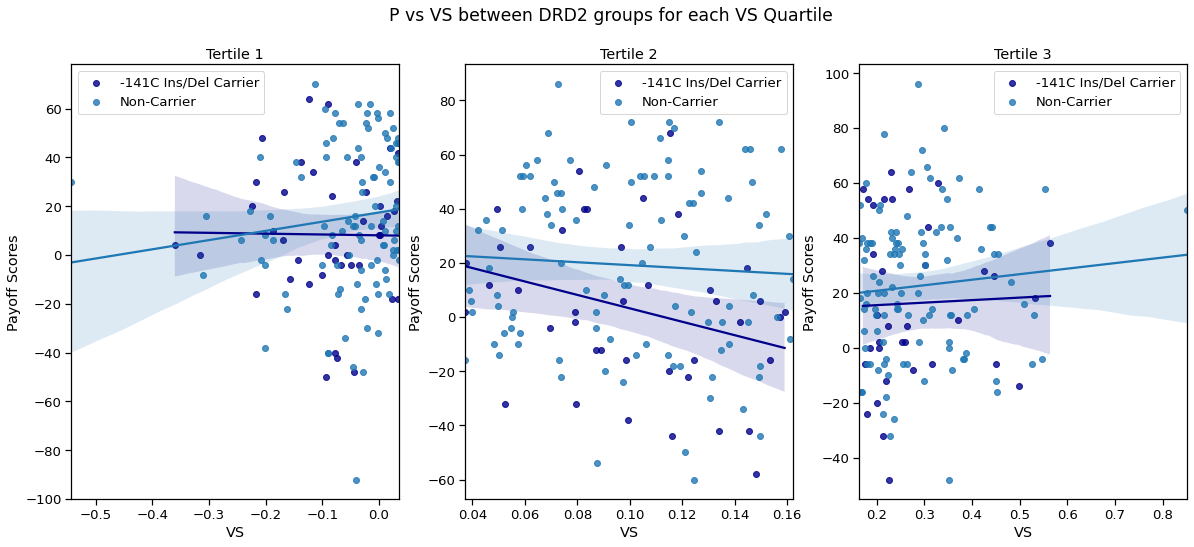

In [87]:
# Configuring grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('P vs VS between DRD2 groups for each VS Quartile\n')

# T1
ax = fig.add_subplot(1, 3, 1)
scatter_P_carrier_1 = sns.regplot(x='VS', y='P', data=VS_data_1T[VS_data_1T["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_1 = sns.regplot(x='VS', y='P', data=VS_data_1T[VS_data_1T["DRD2"]==0], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Tertile 1')

# T2
ax = fig.add_subplot(1, 3, 2)
scatter_P_carrier_2 = sns.regplot(x='VS', y='P', data=VS_data_2T[VS_data_2T["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_2 = sns.regplot(x='VS', y='P', data=VS_data_2T[VS_data_2T["DRD2"]==0], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Tertile 2')

# T3
ax = fig.add_subplot(1, 3, 3)
scatter_P_carrier_3 = sns.regplot(x='VS', y='P', data=VS_data_3T[VS_data_3T["DRD2"]==1], label='-141C Ins/Del Carrier', 
                                  color="darkblue").legend()
scatter_P_noncarrier_3 = sns.regplot(x='VS', y='P', data=VS_data_3T[VS_data_3T["DRD2"]==0], label='Non-Carrier').legend()
ax.set(xlabel='VS')
ax.set(ylabel='Payoff Scores')
ax.set_title('Tertile 3')

